(379, 600)


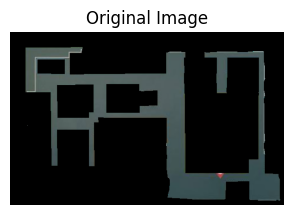

(379, 600)


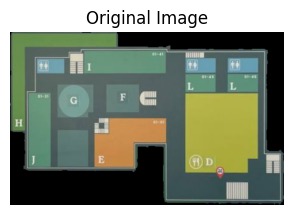

[{'x': 232, 'y': 32}, {'x': 33, 'y': 33}, {'x': 33, 'y': 215}, {'x': 6, 'y': 216}, {'x': 5, 'y': 4}, {'x': 234, 'y': 5}]
1
[{'x': 119, 'y': 91}, {'x': 119, 'y': 60}, {'x': 60, 'y': 60}, {'x': 60, 'y': 90}]
2
[{'x': 39, 'y': 132}, {'x': 88, 'y': 132}, {'x': 90, 'y': 295}, {'x': 40, 'y': 295}]
1
[{'x': 160, 'y': 46}, {'x': 131, 'y': 46}, {'x': 131, 'y': 92}, {'x': 161, 'y': 92}]
3
[{'x': 103, 'y': 214}, {'x': 172, 'y': 214}, {'x': 172, 'y': 294}, {'x': 104, 'y': 294}]
1
[{'x': 182, 'y': 115}, {'x': 182, 'y': 175}, {'x': 172, 'y': 175}, {'x': 172, 'y': 187}, {'x': 104, 'y': 187}, {'x': 103, 'y': 116}]
1
[{'x': 211, 'y': 114}, {'x': 282, 'y': 114}, {'x': 283, 'y': 176}, {'x': 211, 'y': 176}]
1
[{'x': 162, 'y': 42}, {'x': 341, 'y': 42}, {'x': 341, 'y': 90}, {'x': 162, 'y': 91}]
1
[{'x': 322, 'y': 128}, {'x': 322, 'y': 160}, {'x': 284, 'y': 161}, {'x': 284, 'y': 130}]
3
[{'x': 342, 'y': 188}, {'x': 342, 'y': 242}, {'x': 272, 'y': 243}, {'x': 272, 'y': 294}, {'x': 185, 'y': 295}, {'x': 184, '

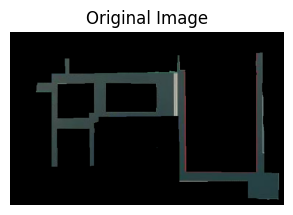

(379, 600)


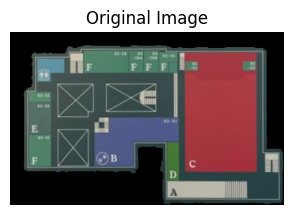

[{'x': 520, 'y': 327}, {'x': 344, 'y': 328}, {'x': 344, 'y': 364}, {'x': 520, 'y': 364}]
3
[{'x': 557, 'y': 307}, {'x': 588, 'y': 308}, {'x': 588, 'y': 266}, {'x': 557, 'y': 266}]
3
[{'x': 370, 'y': 240}, {'x': 343, 'y': 240}, {'x': 343, 'y': 326}, {'x': 370, 'y': 325}]
1
[{'x': 368, 'y': 184}, {'x': 216, 'y': 186}, {'x': 216, 'y': 221}, {'x': 184, 'y': 221}, {'x': 184, 'y': 294}, {'x': 272, 'y': 295}, {'x': 272, 'y': 241}, {'x': 369, 'y': 240}]
1
[{'x': 194, 'y': 196}, {'x': 194, 'y': 186}, {'x': 216, 'y': 186}, {'x': 216, 'y': 221}, {'x': 185, 'y': 221}, {'x': 184, 'y': 199}]
3
[{'x': 173, 'y': 212}, {'x': 103, 'y': 212}, {'x': 104, 'y': 294}, {'x': 174, 'y': 292}]
0
[{'x': 90, 'y': 225}, {'x': 40, 'y': 225}, {'x': 41, 'y': 295}, {'x': 90, 'y': 294}]
1
[{'x': 90, 'y': 224}, {'x': 42, 'y': 224}, {'x': 41, 'y': 153}, {'x': 90, 'y': 153}]
1
[{'x': 90, 'y': 153}, {'x': 90, 'y': 132}, {'x': 40, 'y': 132}, {'x': 41, 'y': 153}]
1
[{'x': 90, 'y': 110}, {'x': 90, 'y': 90}, {'x': 120, 'y': 90}

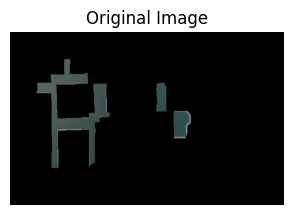

(379, 600)


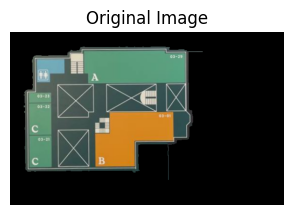

[{'x': 274, 'y': 294}, {'x': 274, 'y': 240}, {'x': 358, 'y': 239}, {'x': 357, 'y': 174}, {'x': 218, 'y': 176}, {'x': 218, 'y': 222}, {'x': 186, 'y': 222}, {'x': 186, 'y': 296}]
1
[{'x': 218, 'y': 186}, {'x': 217, 'y': 222}, {'x': 187, 'y': 222}, {'x': 186, 'y': 198}, {'x': 196, 'y': 198}, {'x': 196, 'y': 188}]
3
[{'x': 172, 'y': 214}, {'x': 172, 'y': 294}, {'x': 106, 'y': 294}, {'x': 105, 'y': 216}]
0
[{'x': 172, 'y': 186}, {'x': 172, 'y': 176}, {'x': 184, 'y': 176}, {'x': 182, 'y': 114}, {'x': 102, 'y': 115}, {'x': 104, 'y': 188}]
0
[{'x': 211, 'y': 114}, {'x': 321, 'y': 114}, {'x': 319, 'y': 127}, {'x': 284, 'y': 128}, {'x': 284, 'y': 158}, {'x': 320, 'y': 158}, {'x': 320, 'y': 173}, {'x': 212, 'y': 175}]
0
[{'x': 320, 'y': 126}, {'x': 283, 'y': 127}, {'x': 284, 'y': 158}, {'x': 321, 'y': 158}]
3
[{'x': 342, 'y': 112}, {'x': 385, 'y': 112}, {'x': 386, 'y': 172}, {'x': 342, 'y': 172}]
0
[{'x': 91, 'y': 226}, {'x': 39, 'y': 226}, {'x': 41, 'y': 297}, {'x': 90, 'y': 298}]
1
[{'x': 90, '

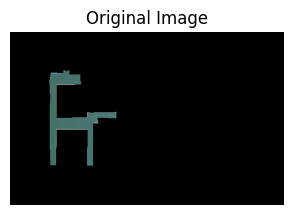

(379, 600)


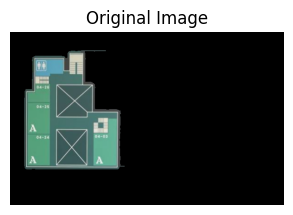

[{'x': 192, 'y': 188}, {'x': 214, 'y': 188}, {'x': 214, 'y': 220}, {'x': 182, 'y': 220}, {'x': 182, 'y': 200}, {'x': 194, 'y': 200}]
3
[{'x': 215, 'y': 189}, {'x': 234, 'y': 189}, {'x': 234, 'y': 294}, {'x': 182, 'y': 294}, {'x': 182, 'y': 221}, {'x': 213, 'y': 220}]
1
[{'x': 169, 'y': 214}, {'x': 102, 'y': 214}, {'x': 101, 'y': 292}, {'x': 168, 'y': 292}]
0
[{'x': 86, 'y': 224}, {'x': 38, 'y': 224}, {'x': 37, 'y': 292}, {'x': 87, 'y': 292}]
1
[{'x': 86, 'y': 224}, {'x': 38, 'y': 224}, {'x': 38, 'y': 156}, {'x': 86, 'y': 156}]
1
[{'x': 87, 'y': 155}, {'x': 86, 'y': 114}, {'x': 55, 'y': 115}, {'x': 55, 'y': 130}, {'x': 36, 'y': 132}, {'x': 37, 'y': 156}]
1
[{'x': 85, 'y': 112}, {'x': 54, 'y': 113}, {'x': 54, 'y': 97}, {'x': 86, 'y': 98}]
3
[{'x': 86, 'y': 98}, {'x': 55, 'y': 97}, {'x': 56, 'y': 60}, {'x': 117, 'y': 60}, {'x': 116, 'y': 89}, {'x': 89, 'y': 88}]
2
[{'x': 130, 'y': 92}, {'x': 160, 'y': 92}, {'x': 161, 'y': 48}, {'x': 130, 'y': 49}]
3
[{'x': 102, 'y': 116}, {'x': 102, 'y': 

In [9]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import base64


def base64_to_image(base64_string):
    # Remove the header if it exists
    if base64_string.startswith("data:image"):
        base64_string = base64_string.split(",")[1]
    
    # Decode the base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    
    # Convert the bytes to a NumPy array
    np_arr = np.frombuffer(image_bytes, np.uint8)
    
    # Decode the NumPy array to an image (assuming a color image)
    image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return image


def plot_image(image):
    print(image.shape[:2])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

with open("data.json") as f:
    data =json.load(f)
    allRegions = (data["drawnRegions"])
    shapes = (data["shapeLabels"])
    walkways = (data["walkways"])
    paddedImages = (data["paddedImages"])
    for index, imageString in enumerate(paddedImages):
        regions = allRegions.get(str(index), [])
        shape = shapes.get(str(index), {})
        image = base64_to_image(walkways[index])
        plot_image(image)
        baseImage = base64_to_image(paddedImages[index])
        plot_image(baseImage)
        # print(regions)
        # print(shape)
        for index, region in enumerate(regions):
            print(region)
            regionType = shape.get(str(index), -1)
            print(regionType)

